In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import nibabel as nib

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import MultiplicativeLR

from torchsummary import summary

%matplotlib inline

They have only one size.

In [2]:
# set(nib.load(b).get_fdata().shape for b in glob('blurred/*.BRIK'))

## Model

In [3]:
from model import *

In [4]:
model = DeepBrain(inplanes=179, planes=3)

G:\My Drive\termpj\model.py:102: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('relu'))


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(summary(model, input_size=(179, 72, 72, 36)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 3, 72, 72, 36]             540
       BatchNorm3d-2        [-1, 3, 72, 72, 36]               6
              ReLU-3        [-1, 3, 72, 72, 36]               0
            Conv3d-4       [-1, 16, 36, 36, 18]           1,312
       BatchNorm3d-5       [-1, 16, 36, 36, 18]              32
              ReLU-6       [-1, 16, 36, 36, 18]               0
            Conv3d-7       [-1, 32, 36, 36, 18]             544
       BatchNorm3d-8       [-1, 32, 36, 36, 18]              64
            Conv3d-9       [-1, 32, 36, 36, 18]          13,856
      BatchNorm3d-10       [-1, 32, 36, 36, 18]              64
             ReLU-11       [-1, 32, 36, 36, 18]               0
           Conv3d-12       [-1, 32, 36, 36, 18]          27,680
      BatchNorm3d-13       [-1, 32, 36, 36, 18]              64
             ReLU-14       [-1, 32, 36,

## DataLoader

In [6]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    
    def __init__(self, datatype='blur', test=False):
        
        if datatype == 'blur':
            self.datafiles = glob('blurred/*.BRIK')
            
        elif datatype == 'scale':
            self.datafiles = glob('scaled/*.BRIK')
            
        else:
            pass
    
        if test: self.datafiles[-5:]
        else: self.datafiles[:-5]
        self.demographics = pd.read_csv('participants_with_runs.csv')
        
    def __getitem__(self, idx):
        
        x = torch.tensor(nib.load(self.datafiles[idx]).get_fdata()).float()
        y = torch.tensor(self.demographics.loc[idx].YB).float()
        
        return x, y
    
    def __len__(self):
        return len(self.datafiles)

In [7]:
dset = MyDataset()
dloader = DataLoader(dset)

## Run

In [8]:
# loss_fn = nn.BCELoss(weight=torch.Tensor([1/44, 1/25]))
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.97)

Epoch 0


C:\Users\pha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 1
              precision    recall  f1-score   support

           0       0.64      0.86      0.74        44
           1       0.40      0.16      0.23        25

    accuracy                           0.61        69
   macro avg       0.52      0.51      0.48        69
weighted avg       0.56      0.61      0.55        69

Epoch 2
              precision    recall  f1-score   support

           0       0.61      0.84      0.70        44
           1       0.12      0.04      0.06        25

    accuracy                           0.55        69
   macro avg       0.37      0.44      0.38        69
weighted avg       0.43      0.55      0.47        69

Epo

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 26
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 27
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

E

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 51
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 52
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

E

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 76
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 77
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

E

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 101
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 102
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69


              precision    recall  f1-score   support

           0       0.68      0.61      0.64        44
           1       0.41      0.48      0.44        25

    accuracy                           0.57        69
   macro avg       0.54      0.55      0.54        69
weighted avg       0.58      0.57      0.57        69

Epoch 126
              precision    recall  f1-score   support

           0       0.69      0.57      0.62        44
           1       0.42      0.56      0.48        25

    accuracy                           0.57        69
   macro avg       0.56      0.56      0.55        69
weighted avg       0.60      0.57      0.57        69

Epoch 127
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        44
           1       0.50      0.64      0.56        25

    accuracy                           0.64        69
   macro avg       0.63      0.64      0.63        69
weighted avg       0.66      0.64      0.64        69


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 151
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 152
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69


              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 176
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69

Epoch 177
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        44
           1       0.00      0.00      0.00        25

    accuracy                           0.64        69
   macro avg       0.32      0.50      0.39        69
weighted avg       0.41      0.64      0.50        69


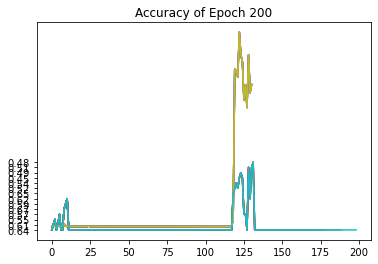

In [9]:
losses, ans, accs = [], [], []
for e in range(200):
    
    print(f"Epoch {e}")
    epoch_pred, epoch_true = [], []
    bth_loss = 0
    for i, (x, y) in enumerate(dloader):
        
        x, y = x.permute(0, 4, 1, 2, 3).to(device), y.to(device)
        epoch_true.append(round(float(y)))
        
        optimizer.zero_grad()
        
        y_pred = model.forward(x).to(device)
        epoch_pred.append(float(y_pred.squeeze(1)))
        
        loss = loss_fn(y_pred.reshape(1), y)
        bth_loss += loss.item()
        
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
    torch.cuda.empty_cache()
    
    losses.append(bth_loss / len(dloader))
    ans.append((epoch_true, epoch_pred))
    
    if e % 10 == 9:
        plt.title(f'Loss of Epoch {e+1}')
        plt.plot(losses)
        plt.grid()
        
        plt.title(f'Accuracy of Epoch {e+1}')
        plt.plot(accs)
        plt.grid()
    
    print(classification_report(epoch_true, np.array(epoch_pred) > 0.5))
    accs.append(classification_report(epoch_true, np.array(epoch_pred) > 0.5).split('\n')[5].split()[1])